# Gaussian process Regression on the Mauna Loa dataset

This example is based on Section 5.4.3 of "Gaussian Processes for Machine Learning" (http://www.gaussianprocess.org/gpml/chapters/RW.pdf). We will mimic the analysis performed in the scikit-learn example (https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html) through the GPyTorch library. 

The data consists of the monthly average atmospheric CO2 concentrations (in parts per million by volume (ppm)) collected at the Mauna Loa Observatory in Hawaii, between 1958 and 2001. The objective is to model the CO2 concentration as a function of the time $t$ and extrapolate for years after 2001.

In [1]:
import torch
import gpytorch
from gpytorch.kernels import (
    Kernel, PeriodicKernel, RBFKernel, RQKernel, ScaleKernel
)
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from typing import Union, Dict, List

from sklearn.datasets import fetch_openml
from botorch import fit_gpytorch_model

%matplotlib inline

## Build the dataset

We will derive a dataset from the Mauna Loa Observatory that collected air
samples. We are interested in estimating the concentration of CO2 and
extrapolate it for further year. First, we load the original dataset available
in OpenML.



In [2]:
co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


In [3]:
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head(10)

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-17,317.5
1958-05-24,317.9
1958-07-05,315.8


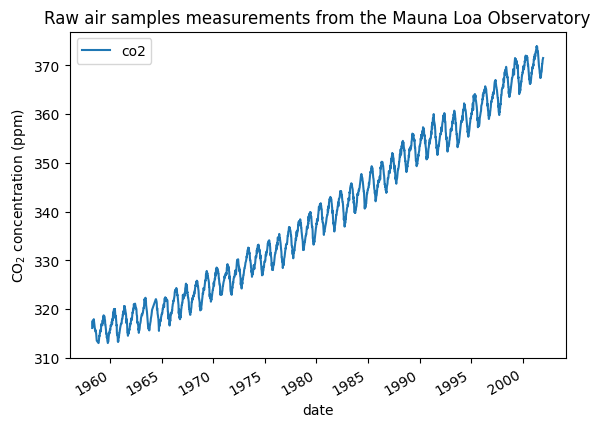

In [4]:
co2_data.plot()
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")

We will preprocess the dataset by taking a monthly average and drop month for which no measurements were collected. Such a processing will have an smoothing effect on the data.

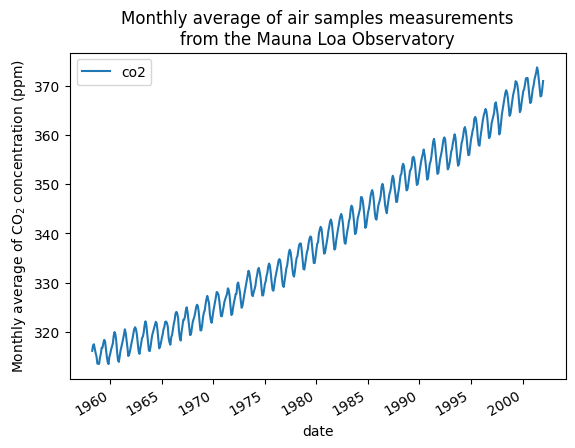

In [5]:
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")
co2_data.plot()
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

As a first step, we will divide the data and the target to estimate. The data being a date, we will convert it into a numeric. We will also standardize the targets for more robust estimation. When forecasting it we can rescale the predictions

In [6]:
# create training and test set 
X_raw = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y_raw = co2_data["co2"].to_numpy()


output_sc = StandardScaler()
y = torch.from_numpy(output_sc.fit_transform(y_raw.reshape(-1,1)).flatten())
X = torch.from_numpy(X_raw)

## GPyTorch model class

In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, gpytorch.likelihoods.GaussianLikelihood())
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Kernel


We will follow the kernel construction in Section 5.4.3 of the book. Some observations about the data at hand: 
long term rising trend, seasonal variations and smaller irregualrities. We will therefore, construct an additive kernel of the form

$$
    k = k_\text{long-term} + k_\text{seasonal} + k_\text{irregular} 
$$

In [8]:
# setup kernels

k_long_term = ScaleKernel(RBFKernel())

# sesonal component
periodic_kernel_yearly = PeriodicKernel()
periodic_kernel_yearly.initialize(**{'period_length':1,'lengthscale':1})
periodic_kernel_yearly.raw_period_length.requires_grad_(False)

k_seasonal = ScaleKernel(
    periodic_kernel_yearly*RBFKernel()
)

# irregularities
k_irregular = ScaleKernel(RQKernel())

kernel = k_long_term + k_seasonal + k_irregular 

**Note**:

Currently, we aren't placing any priors to distinguish the long term RBF kernel from the short-medium term RQ kernel. Using a composite kernel structure with constraints on the lengthscale and amplitudes can improve optimization and quality of the model.


## Model estimation

We will use the `fit_gpytorch_model` function from `botorch` to optimize the kernel hyperparameters using the L-BFGS implementation in `scipy.optimize`. 

In [9]:
model = ExactGPModel(X,y,kernel)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood,model)

_ = fit_gpytorch_model(mll,max_attempts=5)

In [10]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-78.6328], requires_grad=True)),
 ('covar_module.kernels.0.raw_outputscale',
  Parameter containing:
  tensor(7.6923, requires_grad=True)),
 ('covar_module.kernels.0.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[53.7234]], requires_grad=True)),
 ('covar_module.kernels.1.raw_outputscale',
  Parameter containing:
  tensor(-3.6202, requires_grad=True)),
 ('covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale',
  Parameter containing:
  tensor([[2.0890]], requires_grad=True)),
 ('covar_module.kernels.1.base_kernel.kernels.0.raw_period_length',
  Parameter containing:
  tensor([[0.5413]])),
 ('covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale',
  Parameter containing:
  tensor([[114.5845]], requires_grad=True)),
 ('covar_module.kernels.2.raw_outputscale',
  Parameter containing:
  tensor(-1.4451, requires_grad=True)),
 ('covar_module.kernels.2.base_kernel.raw_lengthscale',
  Paramet

## Forecasts

In [11]:
def plot_model(model, train_x, train_y, test_x):
    
    model.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False):

        observed_pred = model.likelihood(model(test_x))
        # bigger plot of the last model
        f, ax = plt.subplots(1, 1, figsize=(12, 6))
        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k.', markersize=4)
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), "-", color="steelblue")
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy().ravel(), lower.numpy(), upper.numpy(), alpha=0.3)

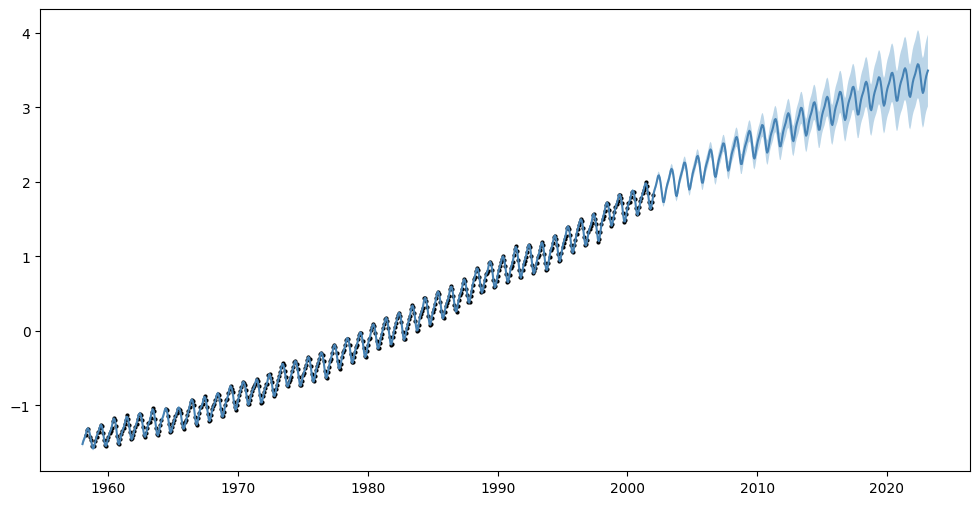

In [12]:
import datetime

today = datetime.datetime.now()
current_month = today.year + today.month / 12
test_x = torch.from_numpy(np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1))

plot_model(model,X,y,test_x)

## Individual components

In [13]:
# extract components from the model's prediction caches
Kinv_dot_y = model.prediction_strategy.mean_cache
Rinv = model.prediction_strategy.covar_cache # RinvRinv^T= Kinv 

In [14]:
comp = [None]*3
for i in range(3):
    with torch.no_grad():
        cov_comp = model.covar_module.kernels[i](*model.train_inputs)
        
    comp[i] = cov_comp @ Kinv_dot_y

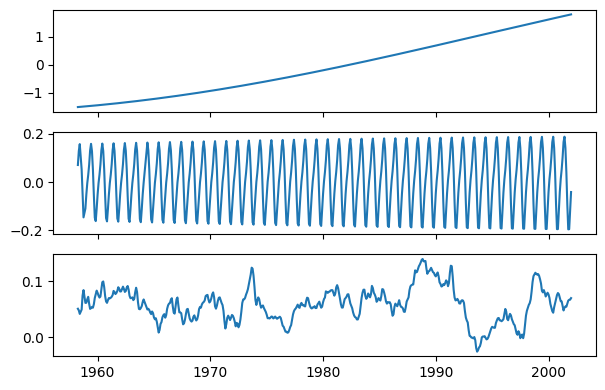

In [15]:
fig,axs = plt.subplots(3,1,figsize=(7,4.5),sharex=True)

for i in range(3):
    _ = axs[i].plot(X,comp[i])

Notice that the irregular component (bottom plot) isn't centered about zero. This needs to be fixed by placing the appropriate constraints on the amplitudes of the kernels.

In [16]:
# # long-term
# with torch.no_grad():
#     cov_long = model.covar_module.kernels[0](*model.train_inputs)
    
# cov_long_dot_Rinv = cov_long @ Rinv
    
# long_term = cov_long @ Kinv_dot_y
# long_term_sd = cov_long.diag() -  (cov_long_dot_Rinv**2).sum(dim=-1)

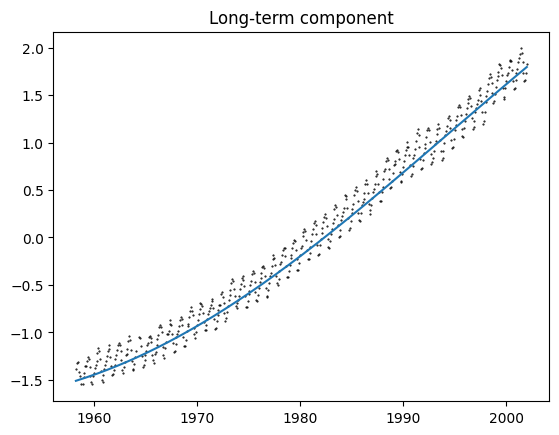

In [17]:
_ = plt.plot(X, y, 'k.', markersize=1)
_ = plt.plot(X,comp[0])
_ = plt.title('Long-term component')